<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [1]:
import os
import sys
import json
import joblib
import geopandas as gpd
import torch
import help_functions as hf
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn 
import help_functions as hf

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

plt.rcParams["font.family"] = "Times New Roman"

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/chenhao-gnn/share/proj failed


In [2]:
# Parameters to adapt

run_path = '../../data/runs_01_2025/'
unique_model_description = "wannabe_best_6/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'
result_path = '../../data/results/results_01_2025/'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
gdf_edges_with_districts = gpd.sjoin(links_base_case, districts, how='left', op='intersects')

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)
loss_fct_mae = torch.nn.L1Loss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - GATConv(512, 64, heads=1): x, edge_in

In [4]:
test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

print(f"Test Loss: {test_loss}")
print(f"R-squared: {r_squared}")
print(f"Baseline Loss: {baseline_loss}")

Test Loss: 24.029377531546814
R-squared: 0.7632392048835754
Baseline Loss: 101.4922103881836


# Next, we will look at single elements of the test set and visualize the performance of the model.


Test 2
Test Loss: 3.6623938424246654
R-squared: 0.8137874007225037
Baseline Loss: 137.67466735839844


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


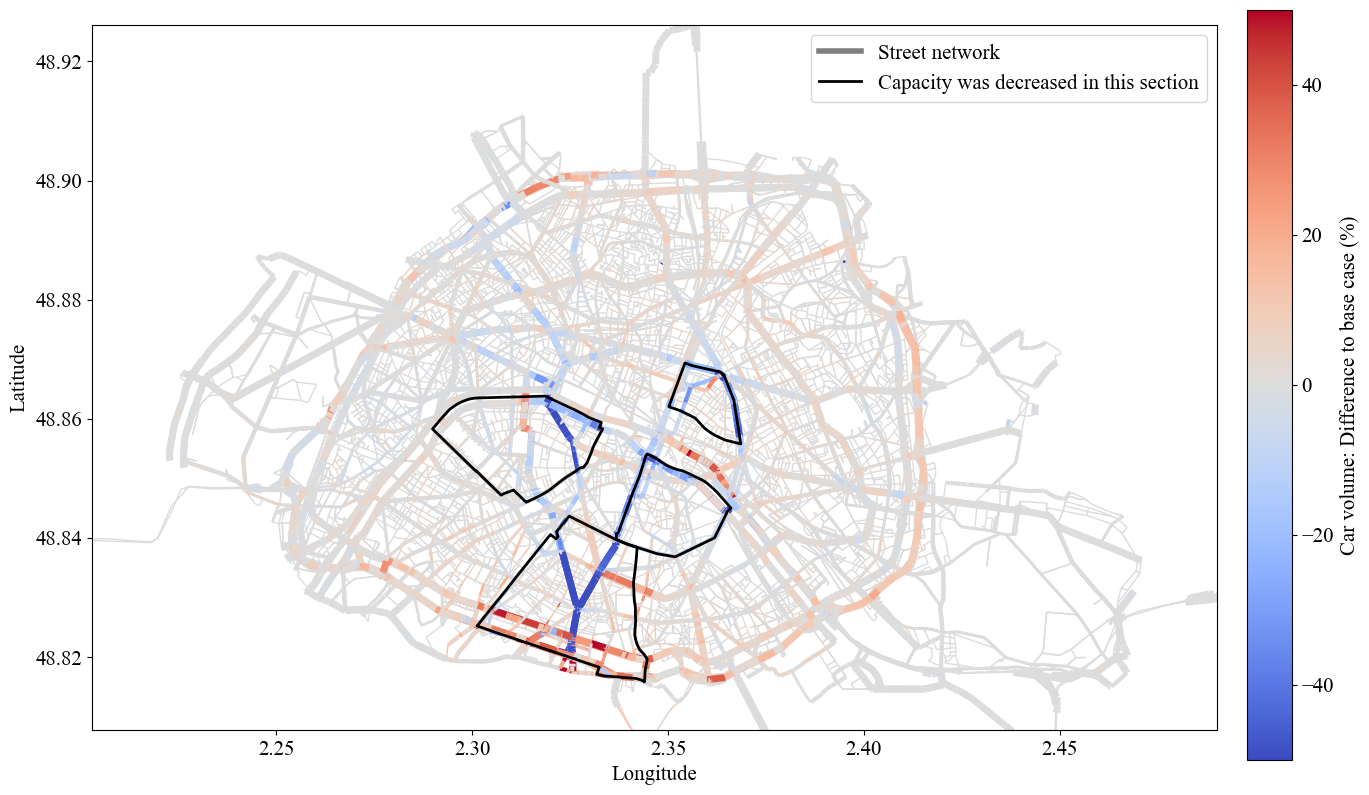

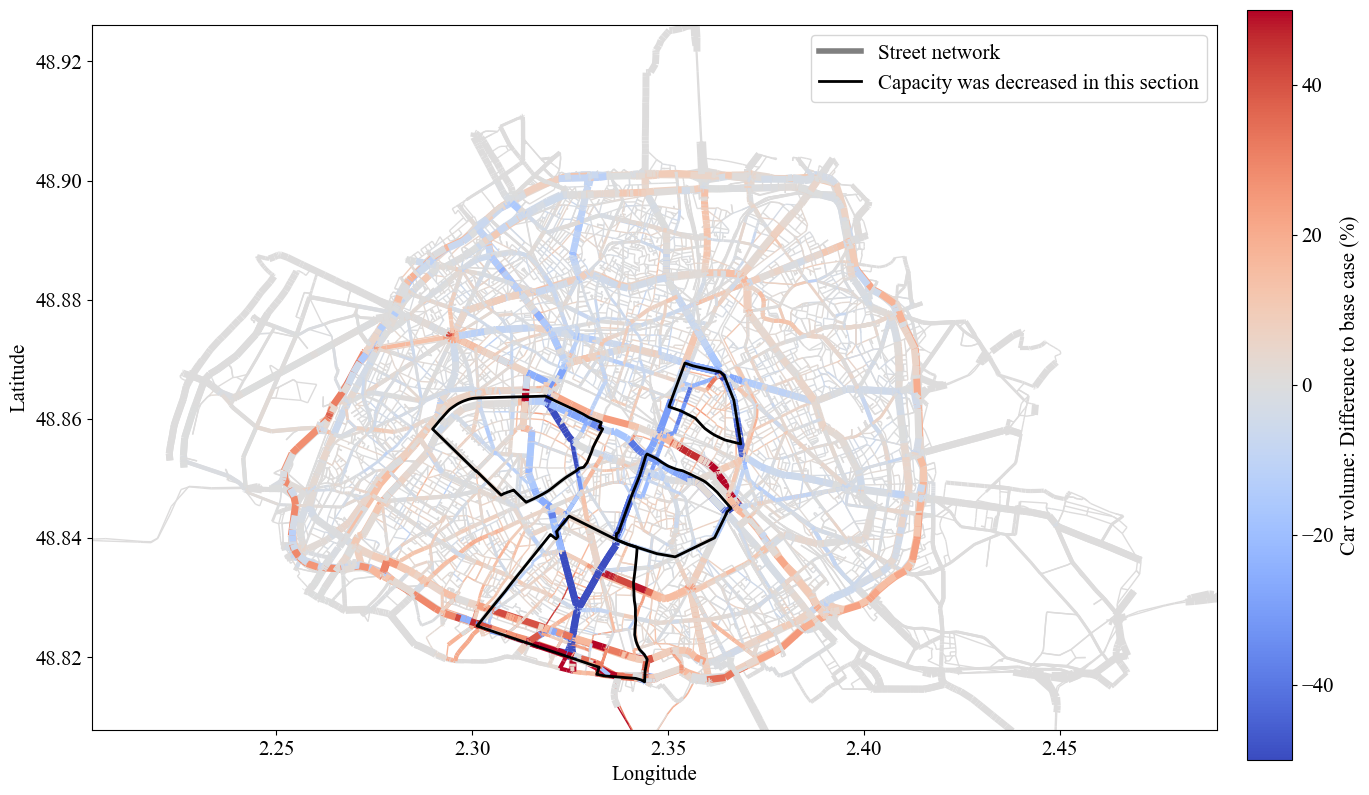

Test 12
Test Loss: 3.450138364519392
R-squared: 0.8146476745605469
Baseline Loss: 130.29762268066406


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


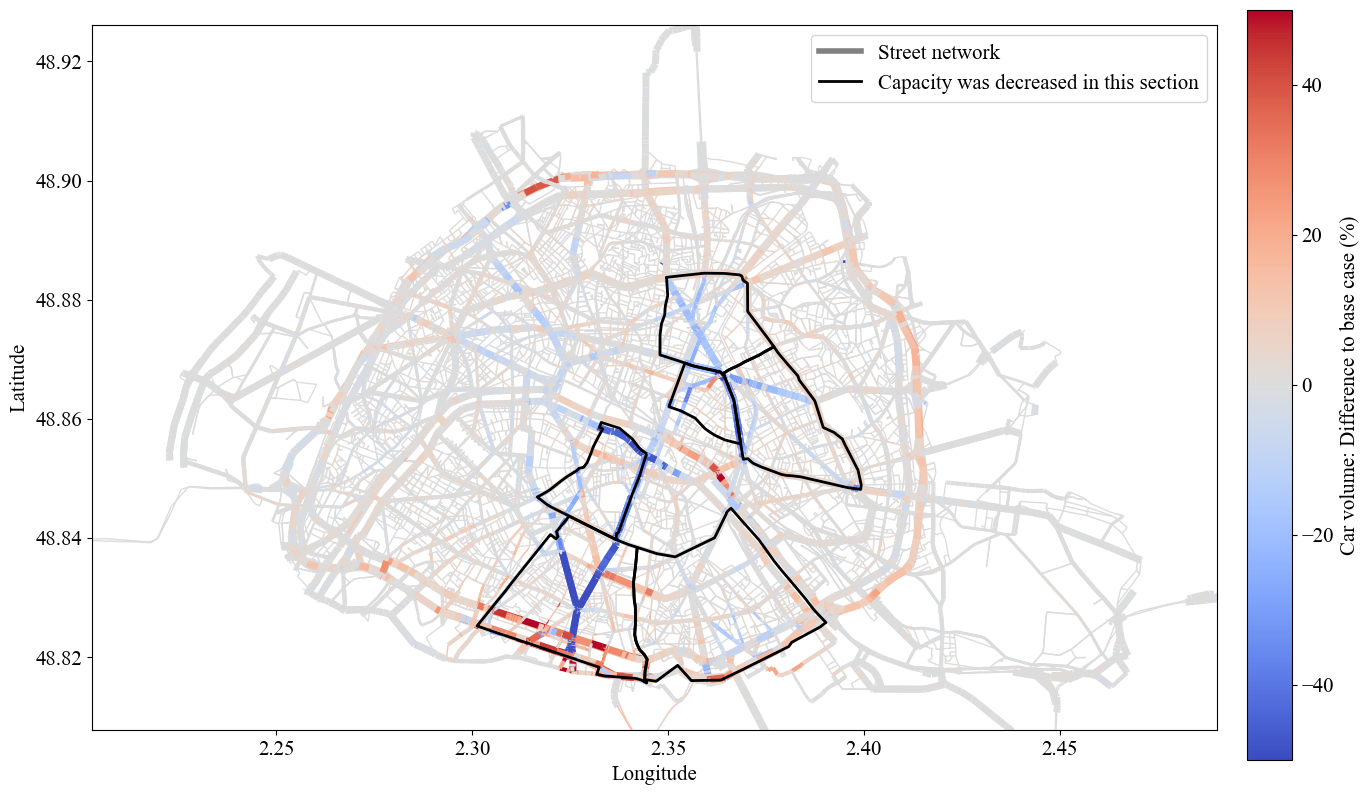

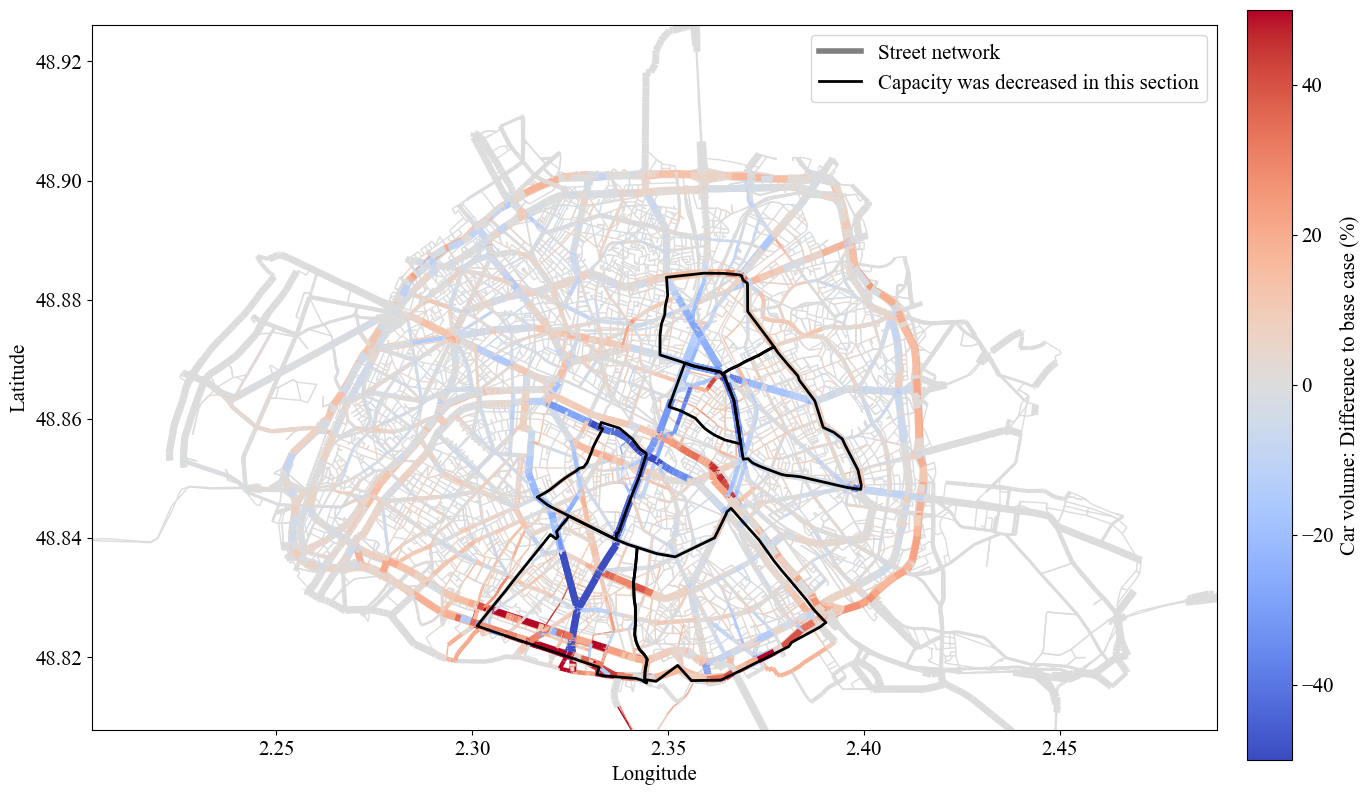

Test 16
Test Loss: 2.452407019478934
R-squared: 0.49796557426452637
Baseline Loss: 34.19456481933594


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


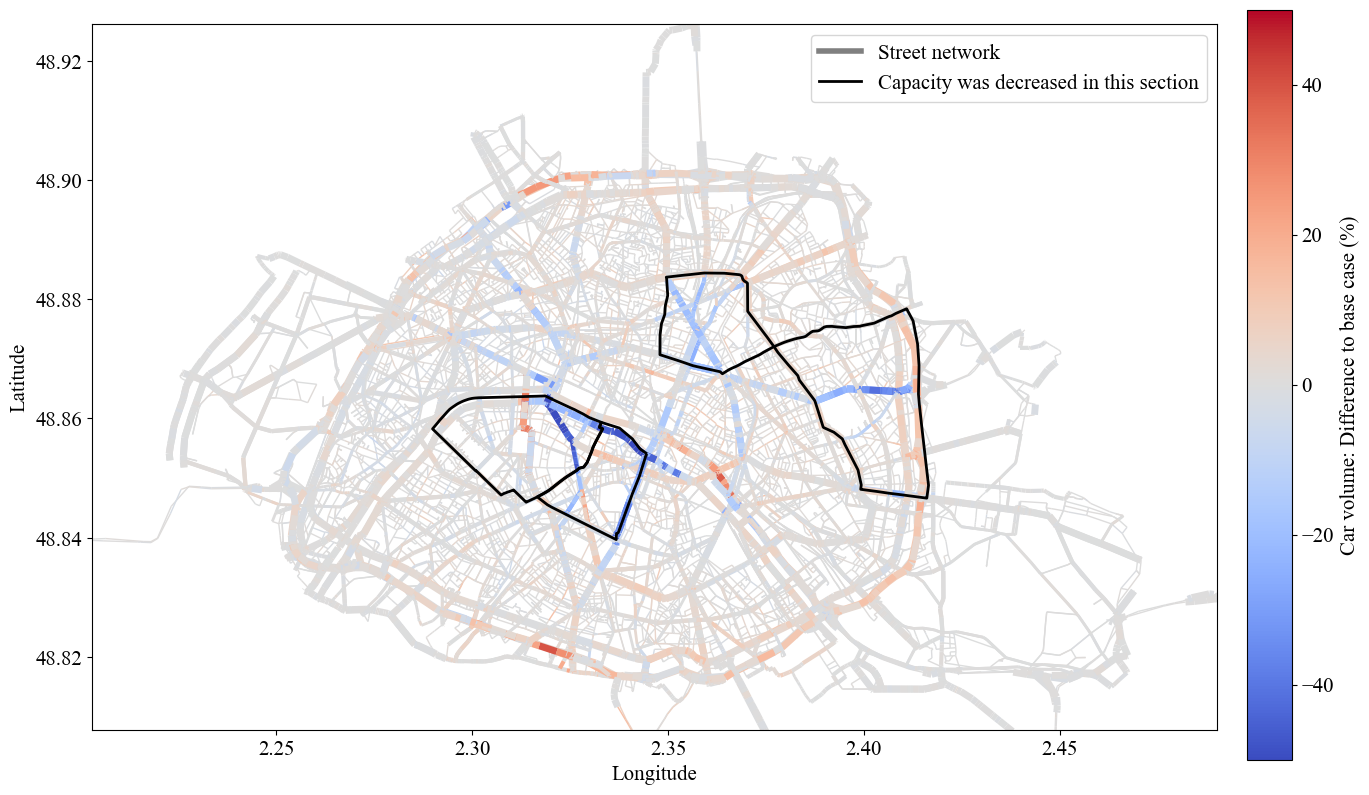

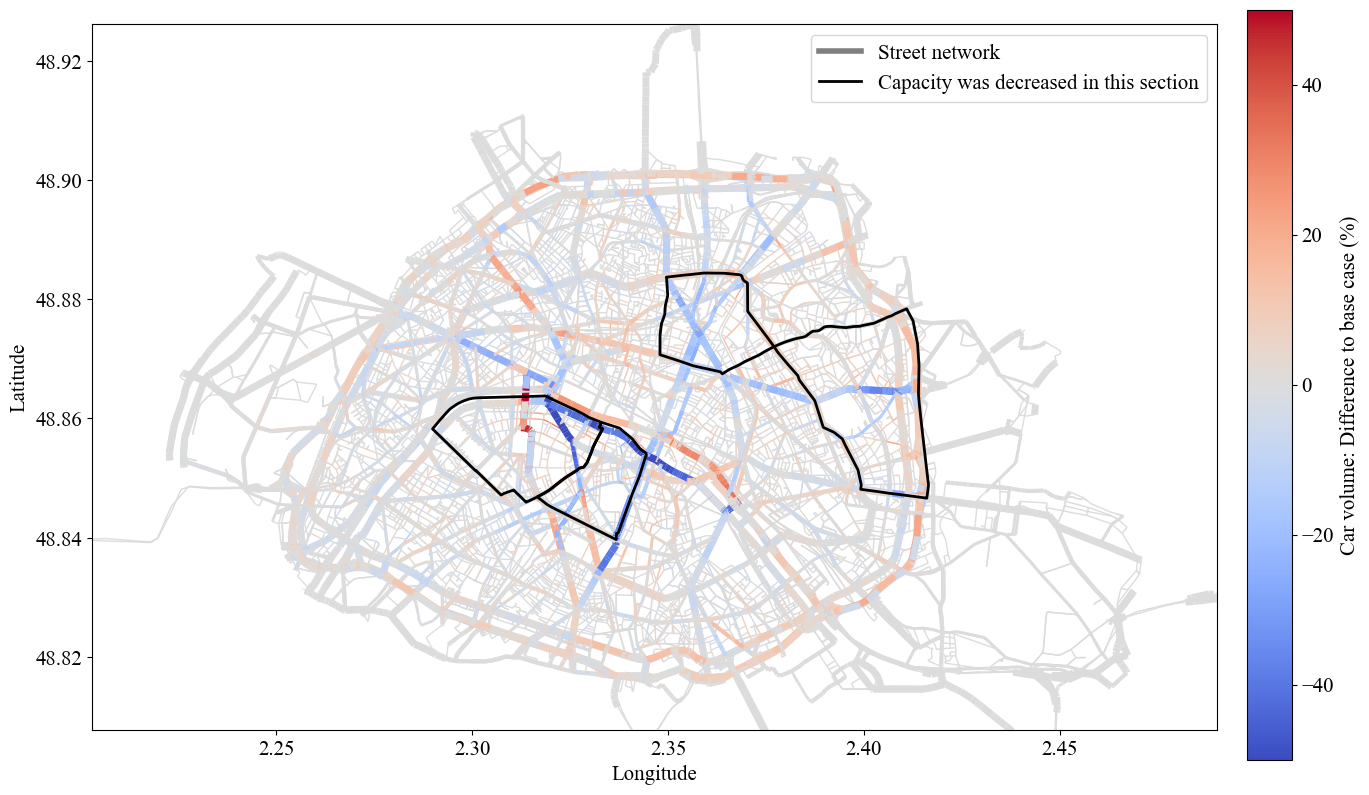

In [5]:
fixed_norm_max = 50

for i in range(50):
    if i != 2 and i != 12 and i != 16:
        continue
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    print(f"Test {i}")
    print(f"Test Loss: {test_loss_my_test_data}")
    print(f"R-squared: {r_squared_my_test_data}")
    print(f"Baseline Loss: {baseline_loss_my_test_data}")

    inversed_x = scaler_x.inverse_transform(my_test_x)

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
    # gdf_with_og_values['district'] = gdf_with_og_values.apply(
    # lambda row: districts[districts.contains(row.geometry)].iloc[0]['c_ar'] if not districts[districts.contains(row.geometry)].empty else 'Unknown',
    # axis=1
    gdf_with_og_values = gpd.sjoin(gdf_with_og_values, districts, how='left', op='intersects')

    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                            save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
    hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                            number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                            fixed_norm_max = fixed_norm_max,
                            known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is de

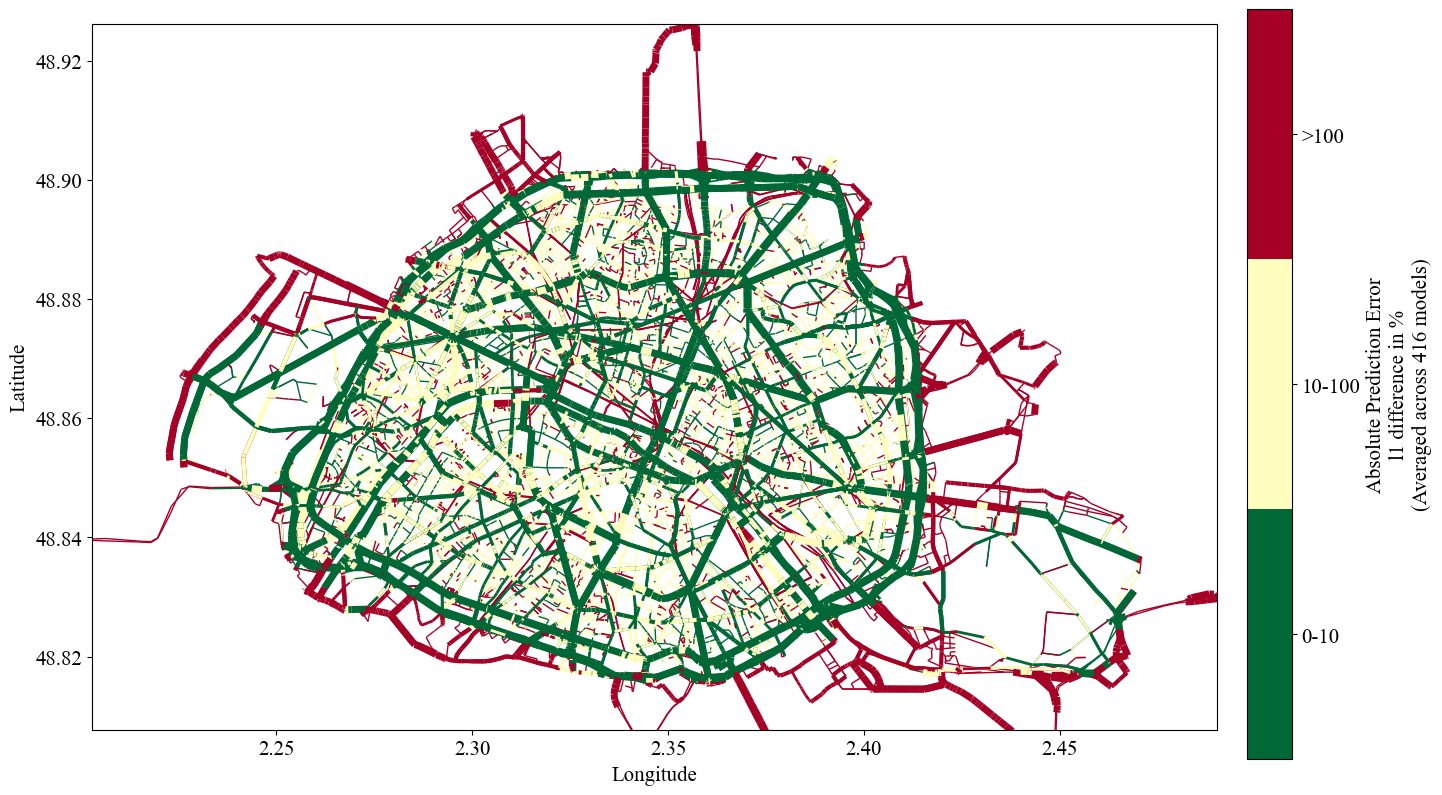

In [6]:
# Generalize the creation of gdfs for a range of indices
gdfs = []
for i in range(len(test_set_loader.dataset)):
    my_test_data = test_set_loader.dataset[i]
    my_test_x = test_set_loader.dataset[i].x
    my_test_x = my_test_x.to('cpu')
    test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
    inversed_x = scaler_x.inverse_transform(my_test_x)
    gdf = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
    gdf = gpd.sjoin(gdf, districts, how='left', op='intersects')
    gdf = gdf.rename(columns={"c_ar": "district"})
    gdf['capacity_reduction_rounded'] = gdf['capacity_reduction'].round(decimals=3)
    gdf['highway'] = gdf['highway'].map(hf.highway_mapping)
    gdfs.append(gdf)
    
# For absolute differences in number of vehicles
result_gdf = hf.plot_average_prediction_differences(
    gdf_inputs=gdfs,
    scale_type="discrete",
    discrete_thresholds=(10, 100),
    save_it=True,
    use_fixed_norm=True,
    fixed_norm_max=100,
    use_absolute_value_of_difference=True,
    use_percentage=True,
    disagreement_threshold=None,
    result_path=result_path,
    loss_fct="l1"
)

# fixed_norm_max = 50

# for i in range(100):
#     if i != 14 and i != 21 and i != 33 and i != 38 and i != 39 and i != 45 and i != 58:
#         continue
#     my_test_data = test_set_loader.dataset[i]
#     my_test_x = test_set_loader.dataset[i].x
#     my_test_x = my_test_x.to('cpu')
    
#     test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = hf.validate_model_on_test_set(model, my_test_data, loss_fct, device)
#     print(f"Test {i}")
#     print(f"Test Loss: {test_loss_my_test_data}")
#     print(f"R-squared: {r_squared_my_test_data}")
#     print(f"Baseline Loss: {baseline_loss_my_test_data}")

#     inversed_x = scaler_x.inverse_transform(my_test_x)

#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
#                             save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)
#     hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
#                             number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
#                             fixed_norm_max = fixed_norm_max,
#                             known_districts = False, buffer = 0.0005, districts_of_interest=None, plot_contour_lines=True, result_path=result_path)

### District analysis
Do all districts appear with the same frequency in the test set? This is investigated below.

In [7]:
# Count district frequency in your scenarios
# district_counts = {}
# for gdf in gdfs:
#     # Get districts where capacity was reduced
#     districts_with_reduction = set(gdf[gdf['capacity_reduction_rounded'] < -1e-3]['district'].unique())
#     for district in districts_with_reduction:
#         district_counts[district] = district_counts.get(district, 0) + 1

# # Print district frequencies
# for district, count in sorted(district_counts.items(), key=lambda x: x[1], reverse=True):
#     print(f"District {district}: {count} times")

# # Check if all primary/secondary/tertiary roads in a district are consistently reduced
# for gdf in gdfs:
#     for district in gdf['district'].unique():
#         main_roads = gdf[(gdf['district'] == district) & 
#                         (gdf['highway'].isin([1,2,3]))]
#         reduced_roads = main_roads[main_roads['capacity_reduction_rounded'] < -1e-3]
#         if len(reduced_roads) > 0 and len(reduced_roads) != len(main_roads):
#             print(f"Inconsistent reduction in district {district}")
            
# # Check average volumes by district
# district_volumes = {}
# for gdf in gdfs:
#     for district in gdf['district'].unique():
#         main_roads = gdf[(gdf['district'] == district) & 
#                         (gdf['highway'].isin([1,2,3]))]
#         avg_volume = main_roads['vol_base_case'].mean()
#         district_volumes[district] = district_volumes.get(district, avg_volume)

# # Print average volumes
# for district, volume in sorted(district_volumes.items(), key=lambda x: x[1], reverse=True):
#     print(f"District {district} average volume: {volume:.2f}")
    
# # Count district frequency in your scenarios
# district_counts = {}
# for gdf in gdfs:
#     # Get districts where capacity was reduced
#     districts_with_reduction = set(gdf[gdf['capacity_reduction_rounded'] < -1e-3]['district'].unique())
#     for district in districts_with_reduction:
#         district_counts[district] = district_counts.get(district, 0) + 1

# # Print district frequencies
# for district, count in sorted(district_counts.items(), key=lambda x: x[1], reverse=True):
#     print(f"District {district}: {count} times")

# # Check if all primary/secondary/tertiary roads in a district are consistently reduced
# for gdf in gdfs:
#     for district in gdf['district'].unique():
#         main_roads = gdf[(gdf['district'] == district) & 
#                         (gdf['highway'].isin([1,2,3]))]
#         reduced_roads = main_roads[main_roads['capacity_reduction_rounded'] < -1e-3]
#         if len(reduced_roads) > 0 and len(reduced_roads) != len(main_roads):
#             print(f"Inconsistent reduction in district {district}")

In [8]:
def validate_model_with_interpretable_error(indices, gdfs):
    """
    Validate model performance across all test set observations for specific road types.
    
    Args:
        indices: Indices of roads to consider for each GDF
        gdfs: List of GeoDataFrames, each representing one test set observation
    """
    loss_fct_l1 = torch.nn.L1Loss()
    loss_fct_l2 = torch.nn.MSELoss()
    
    # Initialize lists to store values across all observations
    all_actual_vals = []
    all_predicted_vals = []
    mean_car_vols = []
    variances = []
    std_devs = []
    std_dev_multiplied = []
    cv_percents = []
    
    # Collect values from all GDFs
    for gdf in gdfs:
        indices = hf.get_road_type_indices(gdf)[road_type]
        
        if len(indices) > 0:  # Only process if we have roads of this type
            actual_vals = gdf.loc[indices, 'vol_car_change_actual']
            predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
            
            all_actual_vals.extend(actual_vals.to_numpy())
            all_predicted_vals.extend(predicted_vals.to_numpy())
            
            # Collect statistics
            mean_car_vols.append(gdf.loc[indices, 'vol_base_case'].mean())
            variances.append(gdf.loc[indices, 'variance'].mean())
            std_devs.append(gdf.loc[indices, 'std_dev'].mean())
            std_dev_multiplied.append(gdf.loc[indices, 'std_dev_multiplied'].mean())
            cv_percents.append(gdf.loc[indices, 'cv_percent'].mean())
    
    # Convert to numpy arrays
    all_actual_vals = np.array(all_actual_vals)
    all_predicted_vals = np.array(all_predicted_vals)
    actual_mean = torch.mean(torch.tensor(all_actual_vals))
    
    # Calculate metrics
    spearman_corr, pearson_corr = hf.compute_correlations_scipy(all_predicted_vals, all_actual_vals)    
    r_squared = hf.compute_r2_torch(preds=torch.tensor(all_predicted_vals), targets=torch.tensor(all_actual_vals))
    
    l1_loss = loss_fct_l1(torch.tensor(all_actual_vals), torch.tensor(all_predicted_vals))
    l2_loss = loss_fct_l2(torch.tensor(all_actual_vals), torch.tensor(all_predicted_vals))
    
    l1_naive = loss_fct_l1(torch.tensor(all_actual_vals), torch.full_like(torch.tensor(all_actual_vals), actual_mean))    
    l2_naive = loss_fct_l2(torch.tensor(all_actual_vals), torch.full_like(torch.tensor(all_actual_vals), actual_mean))
    
    # Calculate averages of statistics
    mean_car_vol = np.mean(mean_car_vols)
    variance = np.mean(variances)
    std_dev = np.mean(std_devs)
    std_dev_multiplied = np.mean(std_dev_multiplied)
    cv_percent = np.mean(cv_percents)
    
    print(" ")
    print(f"Road Type: {road_type}")
    print(f"Number of observations: {len(all_actual_vals)/416}")
    print(f"Mean Car Volume: {mean_car_vol}")
    print(f"R-squared: {round(r_squared.item(), 2)}")
    print(f"MSE Loss: {l2_loss}")
    print(f"Naive MSE Loss: {l2_naive}")
    print(f"Variance: {variance}")
    print(f"L1 Loss: {l1_loss}")
    print(f"Naive L1 loss: {l1_naive}")
    print(f"Standard Deviation Multiplied: {std_dev_multiplied}")
    print(f"Spearman Correlation: {spearman_corr}")
    print(f"Pearson Correlation: {pearson_corr}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Coefficient of Variation: {cv_percent}")
    print(" ")
    
    return {
        'road_type': road_type,
        'number_of_observations': len(all_actual_vals),
        'mean_car_vol': mean_car_vol,
        'r_squared': r_squared,
        'mse': l2_loss,
        'naive_mse': l2_naive,
        'l1': l1_loss,
        'naive_l1': l1_naive,
        'variance': variance,
        'std_dev': std_dev,
        'std_dev_normalized': std_dev_multiplied,
        'spearman': spearman_corr,
        'pearson': pearson_corr,
        'cv_percent': cv_percent
    }

road_types = list(hf.get_road_type_indices(gdfs[0]).keys())

# Then calculate metrics for each road type
metrics_by_type = {}
for road_type in road_types:
    metrics_by_type[road_type] = validate_model_with_interpretable_error(road_type, gdfs)

 
Road Type: All Roads
Number of observations: 35160.0
Mean Car Volume: 52.21265101034725
R-squared: 0.76
MSE Loss: 24.9509334564209
Naive MSE Loss: 103.47013854980469
Variance: 8.878591835668585
L1 Loss: 2.7370145320892334
Naive L1 loss: 3.961287498474121
Standard Deviation Multiplied: 1.7048792843553287
Spearman Correlation: 0.47032497247287586
Pearson Correlation: 0.8711312570814436
Standard Deviation: 2.136749309498867
Coefficient of Variation: 18.65689505679291
 
 
Road Type: Trunk Roads
Number of observations: 1011.0
Mean Car Volume: 505.1565870660825
R-squared: 0.51
MSE Loss: 105.28456115722656
Naive MSE Loss: 216.8148651123047
Variance: 18.8704638398689
L1 Loss: 6.223988056182861
Naive L1 loss: 8.530941009521484
Standard Deviation Multiplied: 2.94609567412481
Spearman Correlation: 0.557301510300573
Pearson Correlation: 0.7172792023981738
Standard Deviation: 3.6923833582646632
Coefficient of Variation: 5.494923339351302
 
 
Road Type: Primary Roads
Number of observations: 6112.0

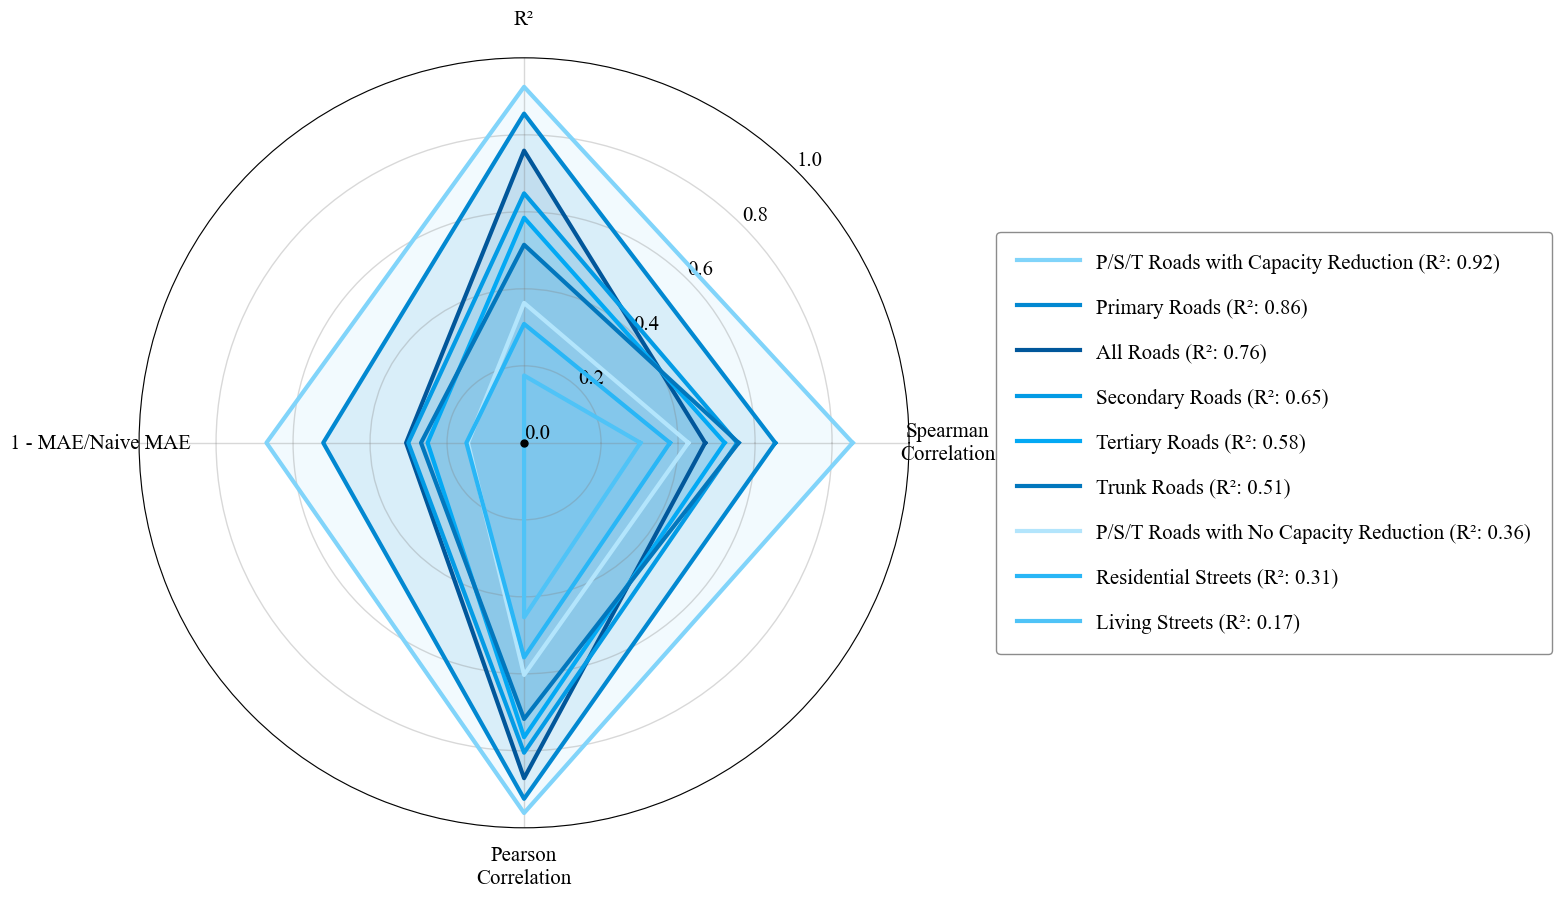

In [12]:
selected_metrics = [
            {
            'id': 'spearman',
            'label': 'Spearman\nCorrelation',
            'transform': lambda x: max(0, x),
            'y_pos': -0.05
            },
            {
                'id': 'r_squared',
                'label': 'R²',
                'transform': lambda x: max(0, x),
                'y_pos': -0.05
            },
            {
                'id': 'l1_ratio',
                'label': '1 - MAE/Naive MAE',
                'transform': lambda x, max_ratio: (1 - x/max_ratio),
                'y_pos': -0.1
            },
            {
                'id': 'pearson',
                'label': 'Pearson\nCorrelation',
                'transform': lambda x: max(0, x),
                'y_pos': -0.05
            }
        ]

hf.create_correlation_radar_plot_sort_by_r2(metrics_by_type, selected_metrics, result_path=result_path, save_it=True)

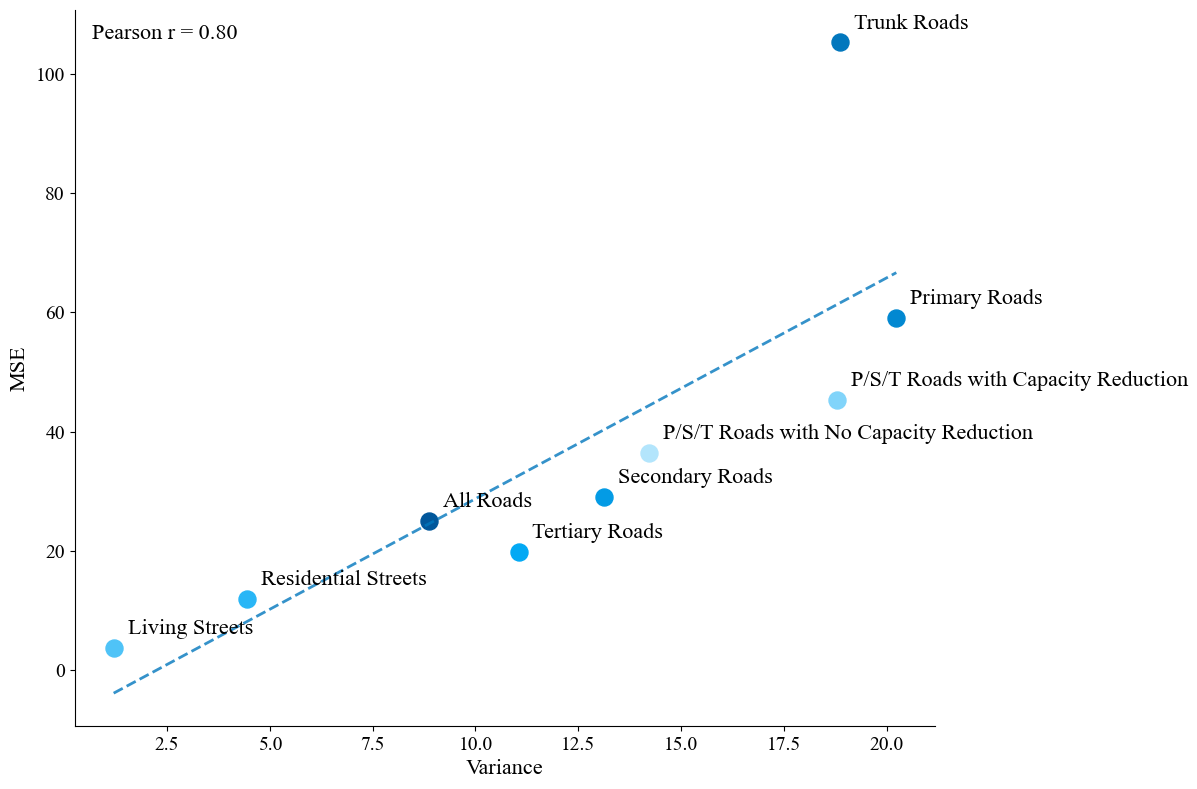

In [10]:
hf.create_error_vs_variability_scatterplots(metrics_by_type, result_path=result_path, save_it=True)

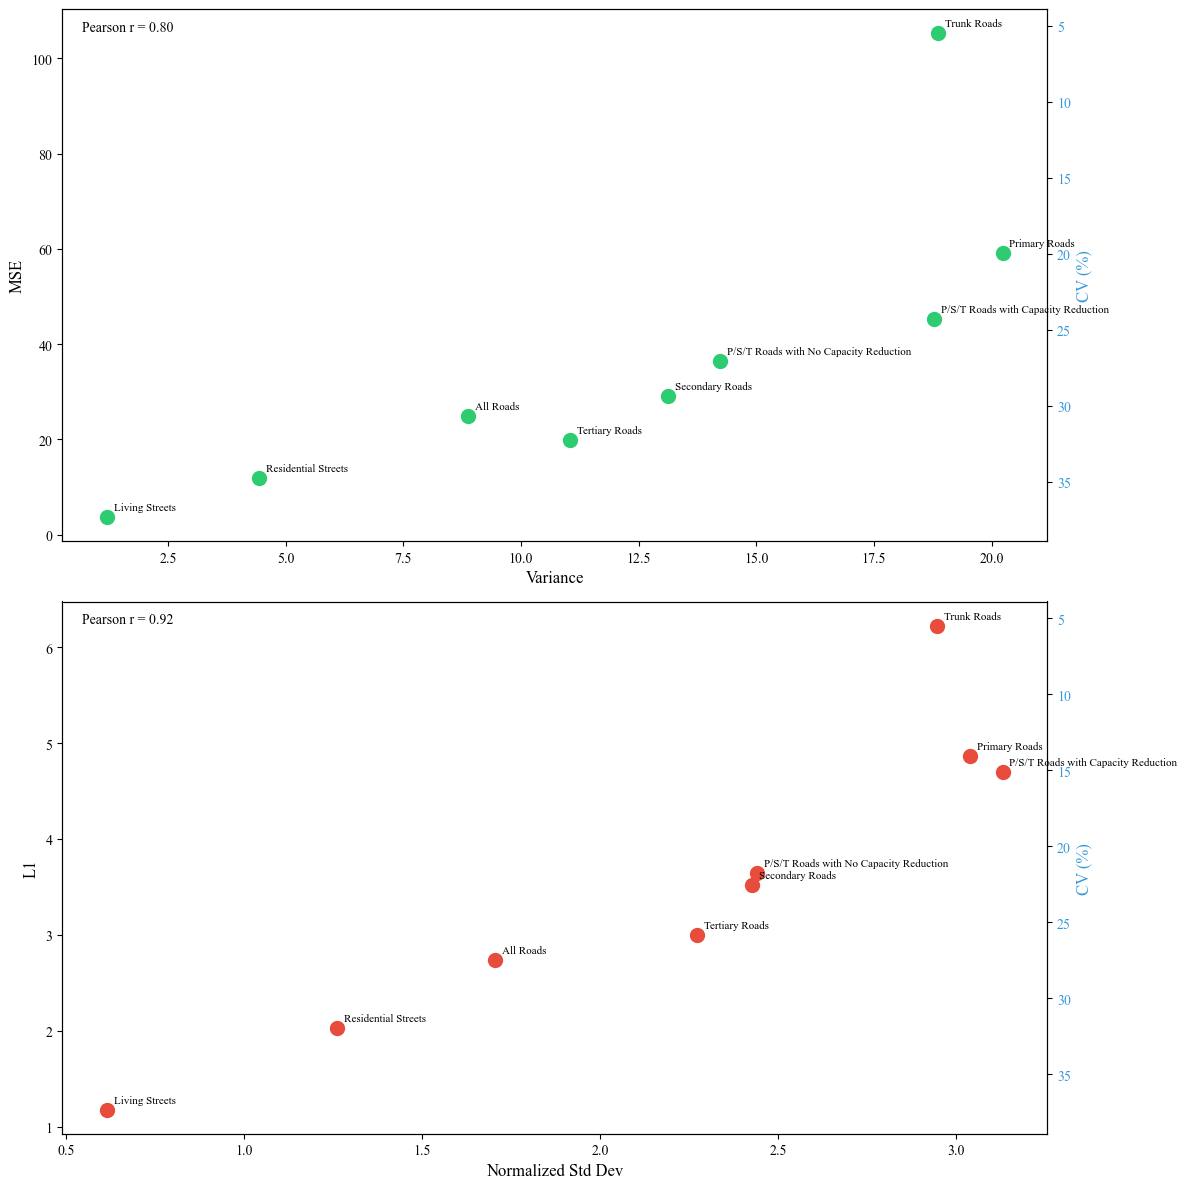

In [11]:
hf.create_error_vs_variability_scatterplots_mse_and_mae(metrics_by_type, result_path=result_path, save_it=False)